# 2b. Sky subtraction and source detection

## 1. Initialisation

### imports:

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
import os  # to manipulate files and directories
import numpy as np
from astropy.io import fits
from time import time as time

from numba import njit
from photutils import segmentation as segm

In [2]:
class SortedData(object):
    
    def __init__(self, data, nbins=None):
        
        t0 = time()
        self.original = data.view()
        self.size = data.size
        self.strides = np.array(data.strides) // data.itemsize
        self.flat = data.ravel()

        print(f'time elapsed: {time()-t0:.3g} s'); t0 = time()
        self.arg_sorted = np.argsort(self.flat)
        print(f'time elapsed: {time()-t0:.3g} s'); t0 = time()
        self.sorted = self.flat[self.arg_sorted]
        #print(f'time elapsed: {time()-t0:.3g} s'); t0 = time()
        valid = np.isfinite(self.sorted)
        self.arg_sorted = self.arg_sorted[valid]
        self.sorted = self.sorted[valid]
        self.n_valid = self.sorted.size
        #print(f'time elapsed: {time()-t0:.3g} s'); t0 = time()
        
        self.x_rho, self.rho = self.probability_density()
        weight = self.rho**2
        self.mode = np.sum(self.x_rho*weight) / np.sum(weight)
        self.index_mode = np.searchsorted(self.sorted, self.mode, side='right')
        self.bg_std = np.sqrt(np.mean((self.sorted[:self.index_mode] - self.mode)**2))
        #print(f'time elapsed: {time()-t0:.3g} s'); t0 = time()

        self.rho_symmetric =  np.interp(2*self.mode-self.x_rho, self.x_rho, self.rho, left=0, right=0)
        self.bg_fraction = np.clip(self.rho_symmetric/self.rho, 0, 1)
        #print(f'time elapsed: {time()-t0:.3g} s'); t0 = time()
        
        self.n_signal = self.n_valid - 2*self.index_mode +1
        #self.n_signal = self.n_valid - self.index_mode
        self.threshold = self.sorted[-self.n_signal]
        self.contamination = np.count_nonzero(self.sorted < 2*self.mode-self.threshold)
        self.purity = 1 - self.contamination/self.n_signal
        self.completeness = 1 - self.contamination/self.n_signal
        print(f'time elapsed: {time()-t0:.3g} s'); t0 = time()

        
    def probability_density(self):
        
        nbins = int(np.sqrt(4*self.n_valid + 1) - 1)

        bins_m = np.arange(nbins+1)
        bins_m = bins_m*(bins_m+1)//2
        half = bins_m.size // 2
        bins_m[bins_m.size-half:] = self.n_valid-1 - bins_m[half-1::-1]
        bins_x = self.sorted[bins_m]

        x = (bins_x[1:] + bins_x[:-1]) / 2
        rho = (bins_m[1:] - bins_m[:-1]) / (bins_x[1:] - bins_x[:-1])
        # median filter:
        #rho = np.nanmedian(np.vstack([rho[:-2], rho[1:-1], rho[2:]]), axis=0)
        #x = np.hstack([self.sorted[0], x[1:-1], self.sorted[-1]])
        #rho = np.hstack([1/(self.sorted[1]-self.sorted[0]), rho, 1/(self.sorted[-1]-self.sorted[-2])])

        return x, rho/self.n_valid


## 2. Read data

### select one dataset:

In [3]:
data_folder = '.'  # location of the observational data within your hard disk (by default, this directory)
reduced_folder = os.path.join(data_folder, 'reduced')  # location of the reduced science exposures

In [4]:
object_name = 'NGC2420'
band = 'V'
dataset = os.path.join(reduced_folder, object_name, band, 'uamA_0033.fits')

In [5]:
plots = False

In [6]:
plots = True

2D images:

In [7]:
hdu = fits.open(dataset)
data = SortedData(hdu[0].data.astype(np.float32))

time elapsed: 4.96e-05 s
time elapsed: 0.135 s
time elapsed: 0.0133 s


### visual inspection:

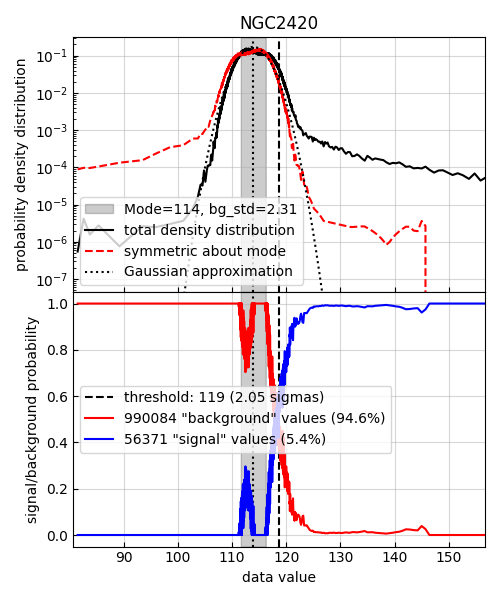

In [8]:
if plots:
    plt.close('density')
    fig = plt.figure('density', figsize=(5, 6))
    ax = fig.subplots(nrows=2, ncols=1, squeeze=False,
                      sharex='col', sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        axis.set_aspect('auto')
        axis.axvline(data.mode, c='k', ls=':')
        shade = axis.fill_between(data.x_rho, 0, 1, where=np.abs(data.x_rho-data.mode) <= data.bg_std,
                          color='k', alpha=0.2, transform=axis.get_xaxis_transform(),
                          label=f'Mode={data.mode:.3g}, bg_std={data.bg_std:.3g}')
        th_line = axis.axvline(data.threshold, c='k', ls='--')
    fig.set_tight_layout(True)

    ax[0, 0].set_title(object_name)
    ax[0, 0].set_ylabel('probability density distribution')
    ax[0, 0].set_yscale('log')
    ax[0, 0].set_ylim(np.min(data.rho[data.x_rho > data.mode]), 2*np.max(data.rho))
    ax[0, 0].plot(data.x_rho, data.rho, 'k-', label='total density distribution')
    ax[0, 0].plot(data.x_rho, data.rho_symmetric, 'r--', label='symmetric about mode')
    ax[0, 0].plot(data.x_rho,
                  np.exp(-.5*((data.x_rho-data.mode)/data.bg_std)**2) * data.n_valid/data.size/np.sqrt(2*np.pi)/data.bg_std,
                  'k:', label='Gaussian approximation')
    ax[0, 0].legend()

    ax[1, 0].set_ylabel('signal/background probability')
    #ax[1, 0].set_yscale('log')
    #ax[1, 0].set_ylim(np.min(reliable_signal_probability), 1.5)
    ax[1, 0].plot(data.x_rho, data.bg_fraction, 'r-',
                  label=f'{2*data.index_mode} "background" values ({200*data.index_mode/data.n_valid:.1f}%)')
    ax[1, 0].plot(data.x_rho, 1-data.bg_fraction, 'b-',
                  label=f'{data.n_signal} "signal" values ({100*data.n_signal/data.n_valid:.1f}%)')
    shade.set_label('')
    th_line.set_label(f'threshold: {data.threshold:.3g} ({(data.threshold-data.mode)/data.bg_std:.3g} sigmas)')
    ax[1, 0].legend(loc='center left')

    ax[-1, 0].set_xlim(data.sorted[0], 2*data.threshold-data.sorted[0])
    ax[-1, 0].set_xlabel('data value')


Contamination: $M_{bg}(>x)$

Purity: $P(x) = \frac{ M_{src}(>x) }{ M(>x) } = 1 - \frac{ M_{bg}(>x) }{ M(>x) }$

Completeness: $C(x) = \frac{ M_{src}(>x) }{ M_{src} } = \frac{ M(>x) }{ M_{src} } P(x) $

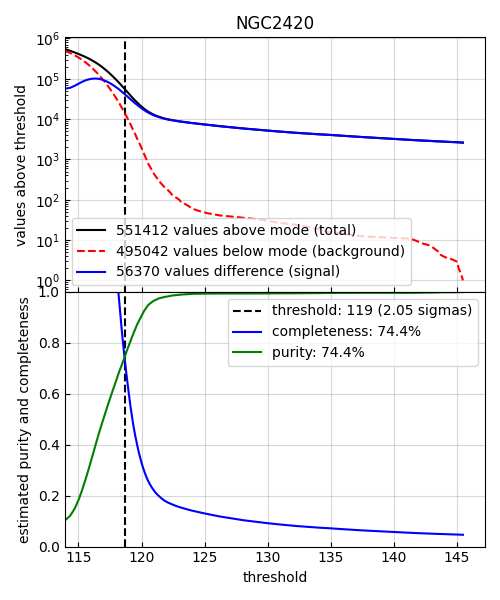

In [9]:
if plots:
    plt.close('completeness-purity')
    fig = plt.figure('completeness-purity', figsize=(5, 6))
    ax = fig.subplots(nrows=2, ncols=1, squeeze=False,
                      sharex='col', sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        axis.set_aspect('auto')
        th_line = axis.axvline(data.threshold, c='k', ls='--')
    fig.set_tight_layout(True)


    index_mode = np.searchsorted(data.sorted, data.mode, side='right')
    n_above_mode = data.n_valid - index_mode
    n_signal = data.n_valid - 2*index_mode
    
    bg_above_threshold = np.logspace(0, np.log10(index_mode), 100)
    threshold = 2*data.mode - np.interp(bg_above_threshold, np.arange(index_mode), data.sorted[:index_mode])
    bg_above_threshold = bg_above_threshold[::-1]
    threshold = threshold[::-1]
    total_above_threshold = np.interp(threshold, data.sorted[index_mode:], n_above_mode-np.arange(n_above_mode))
    signal_above_threshold = total_above_threshold - bg_above_threshold

    completeness = signal_above_threshold / n_signal
    purity = signal_above_threshold / total_above_threshold
    
    ax[0, 0].set_title(object_name)
    ax[0, 0].set_ylabel('values above threshold')
    ax[0, 0].set_yscale('log')
    ax[0, 0].plot(threshold, total_above_threshold, 'k-', label=f'{n_above_mode} values above mode (total)')
    ax[0, 0].plot(threshold, bg_above_threshold, 'r--', label=f'{index_mode} values below mode (background)')
    ax[0, 0].plot(threshold, signal_above_threshold, 'b-', label=f'{n_above_mode-index_mode} values difference (signal)')
    th_line.set_label(f'threshold: {data.threshold:.3g} ({(data.threshold-data.mode)/data.bg_std:.3g} sigmas)')
    ax[0, 0].legend()

    ax[1, 0].set_ylabel('estimated purity and completeness')
    ax[1, 0].plot(threshold, completeness, 'b-', label=f'completeness: {100*data.completeness:.1f}%')
    ax[1, 0].plot(threshold, purity, 'g-', label=f'purity: {100*data.purity:.1f}%')
    ax[1, 0].legend()
    ax[1, 0].set_ylim(0, 1)

    ax[-1, 0].set_xlim(data.mode, 2*data.mode-data.sorted[0])
    ax[-1, 0].set_xlabel('threshold')


In [10]:
data_dimensionality = len(data.strides)
colour_scale = colors.SymLogNorm(vmin=data.sorted[0],
                                 #linthresh=data.threshold,
                                 linthresh=2*data.mode-data.sorted[0],
                                 vmax=data.sorted[-1])

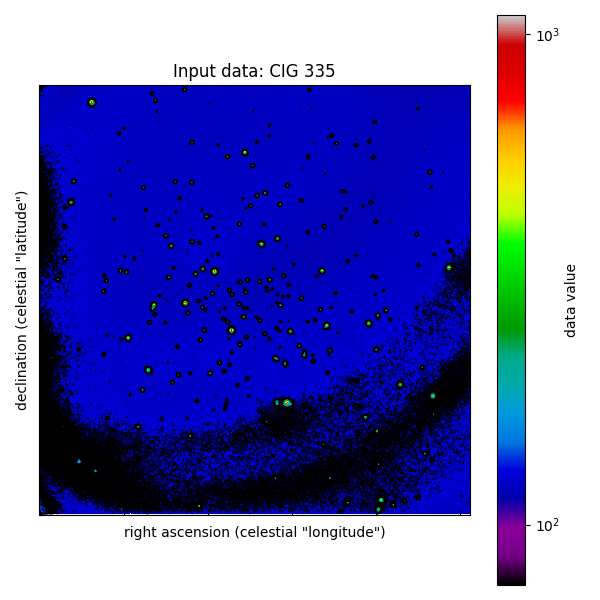

In [11]:
if plots and data_dimensionality == 2:
    plt.close('data')
    fig = plt.figure('data', figsize=(6, 6))
    ax = fig.subplots()
    ax.tick_params(which='both', direction='in')
    fig.set_tight_layout(True)

    im = ax.imshow(data.original,
                   interpolation='nearest', origin='lower',
                   cmap='nipy_spectral', norm=colour_scale,
                  )
    ax.set_title('Input data: CIG 335')
    ax.set_ylabel('declination (celestial "latitude")')
    ax.set_xlabel('right ascension (celestial "longitude")')
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    #ax.contour(data.original, levels=[reliable_x], colors=['w'])
    #ax.contour(data.original, levels=[2*data.mode-data.sorted[0]], colors=['w'])
    ax.contour(data.original, levels=[data.threshold], colors=['k'])
    #ax.contour(data.original, levels=[2*data.mode-data.threshold], colors=['k'])
    cb = fig.colorbar(im, ax=ax)
    #cb.ax.axhline(2*data.mode-data.sorted[0], c='w')
    #cb.ax.axhline(data.threshold, c='k')
    #cb.ax.axhline(2*data.mode-data.threshold, c='k', ls='--')
    cb.ax.set_ylabel('data value')
    plt.show()

## 3. Hierarchical Overdensity Tree (HOT)

### routine definition: 

In [12]:
@njit
def hot(data, sorted_strides, argsorted_data, inverted=False, n_pixels=0):
    """Hierarchical Overdenity Tree (HOT)"""

    dimensions = len(data.strides)
    flat_data = data.ravel()
    
    label = np.zeros(data.size, dtype=np.int32)
    n_labels = 0
    
    n_peaks_max = 1 + data.size//2**dimensions  # maximum number of peaks
    parent = np.zeros(n_peaks_max, dtype=np.int32)
    area = np.zeros(n_peaks_max, dtype=np.int32)
    sum_value = np.zeros(n_peaks_max, dtype=np.float64)
    sum_sqare_value = np.zeros(n_peaks_max, dtype=np.float64)
    #max_signal_to_noise = np.zeros(n_peaks_max, dtype=np.float32)
    #signal_to_noise_area = np.zeros(n_peaks_max, dtype=np.int32)

    if inverted:
        sorted_index = 0  # minimum
        direction = 1
    else:
        sorted_index = argsorted_data.size  # maximum
        direction = -1
    if n_pixels <= 0:
        n_pixels = argsorted_data.size

    pixels_so_far = 0

    while pixels_so_far < n_pixels:
        pixel = argsorted_data[sorted_index]
        pixel_value = flat_data[pixel]
        pixels_so_far += 1
        sorted_index += direction

        neighbour_parents = []
        for dim in range(dimensions):
            stride = sorted_strides[dim]
            remainder = pixel % sorted_strides[dim+1]  # Remember DIRTY HACK 1? ;^D
            if remainder >= stride:  # not at the "left border"
                p = label[pixel-stride]
                while p > 0:
                    pp = parent[p]
                    if pp == p:
                        break
                    else:
                        p = pp
                if p > 0 and p not in neighbour_parents:
                    neighbour_parents.append(p)
            if remainder < sorted_strides[dim+1]-stride:  # not at the "right border"
                p = label[pixel+stride]
                while p > 0:
                    pp = parent[p]
                    if pp == p:
                        break
                    else:
                        p = pp
                if p > 0 and p not in neighbour_parents:
                    neighbour_parents.append(p)

        neighbour_parents = np.array(neighbour_parents)
        n_parents = neighbour_parents.size
        if n_parents == 0:
            n_labels += 1
            selected_parent = n_labels
            parent[n_labels] = n_labels
        elif n_parents == 1:
            selected_parent = neighbour_parents[0]
        else:
            selected_parent = neighbour_parents[np.argmax(area[neighbour_parents])]
            for p in neighbour_parents:
                parent[p] = selected_parent

        label[pixel] = selected_parent
        area[selected_parent] += 1
        sum_value[selected_parent] += pixel_value
        sum_sqare_value[selected_parent] += pixel_value**2
        #n = area[selected_parent]
        #signal_to_noise = (sum_value[selected_parent] - n*smoothed_pixel_value) / np.sqrt(n)
        #if signal_to_noise > max_signal_to_noise[selected_parent]:
        #    max_signal_to_noise[selected_parent] = signal_to_noise
        #    signal_to_noise_area[selected_parent] = n
    
    n_src = np.count_nonzero(label)
    indep = np.where(parent[1:n_labels+1] == np.arange(1,n_labels+1))
    print(f'{n_labels} overdensities found:',
          f'{n_src} "pixels" ({int(100*n_src/data.size)}%),',
          f'{indep[0].size} independent regions',
         )
    area[0] = data.size-n_src
    catalog = (parent[:n_labels+1],
               area[:n_labels+1],
               #sum_value[:n_labels+1],
               #sum_sqare_value[:n_labels+1],
               np.sqrt((sum_sqare_value[:n_labels+1]/area[:n_labels+1] - (sum_value[:n_labels+1]/area[:n_labels+1])**2) * (area[:n_labels+1] - 1)),
               #max_signal_to_noise[:n_labels+1],
               #signal_to_noise_area[:n_labels+1],
              )

    return label.reshape(data.shape), catalog


### selection based on inverted image:

In [13]:
t0 = time()

label, catalog_inv = hot(data.original,
                         np.hstack([np.sort(data.strides), data.size]), # DIRTY HACK when testig particles at the boundary
                         data.arg_sorted,
                         inverted=True,
                         #n_pixels=data.contamination,
                         n_pixels=data.index_mode,
                        )
area_inv = catalog_inv[1]
test_stat_inv = catalog_inv[2]/np.std(data.sorted[:index_mode])
print(f'time elapsed: {time()-t0:.3g} s')

137527 overdensities found: 495042 "pixels" (47%), 27456 independent regions
time elapsed: 3.49 s


### analysis of the normal image:

In [14]:
t0 = time()

label, catalog = hot(data.original,
                     np.hstack([np.sort(data.strides), data.size]), # DIRTY HACK when testig particles at the boundary
                     data.arg_sorted,
                     inverted=False,
                     #n_pixels=data.n_signal,
                     n_pixels=data.n_valid-data.index_mode,
                    )
parent = catalog[0]
area = catalog[1]
test_stat = catalog[2]/np.std(data.sorted[:index_mode])
print(f'time elapsed: {time()-t0:.3g} s')

151222 overdensities found: 551412 "pixels" (52%), 41649 independent regions
time elapsed: 0.225 s


### selectrion criterion:

In [15]:
ts = SortedData(test_stat[test_stat > 0])
ts_inv = SortedData(test_stat_inv[test_stat_inv > 0])
#ts = SortedData(test_stat)
#ts_inv = SortedData(test_stat_inv)

ts_rho_interp = np.exp(np.interp(np.log(ts_inv.x_rho), np.log(ts.x_rho), np.log(ts.rho)))
selection_threshold = np.max(ts_inv.x_rho[ts_inv.rho >= .5*ts_rho_interp])
reliable_threshold = ts_inv.sorted[-1]

ts_inv_reliability = np.clip(1 - ts_inv.rho/ts_rho_interp, 0, 1)
ts_inv_reliability[ts_inv.x_rho < selection_threshold] = 0

time elapsed: 2.36e-05 s
time elapsed: 0.00466 s
time elapsed: 0.000638 s
time elapsed: 2.17e-05 s
time elapsed: 0.00482 s
time elapsed: 0.00101 s


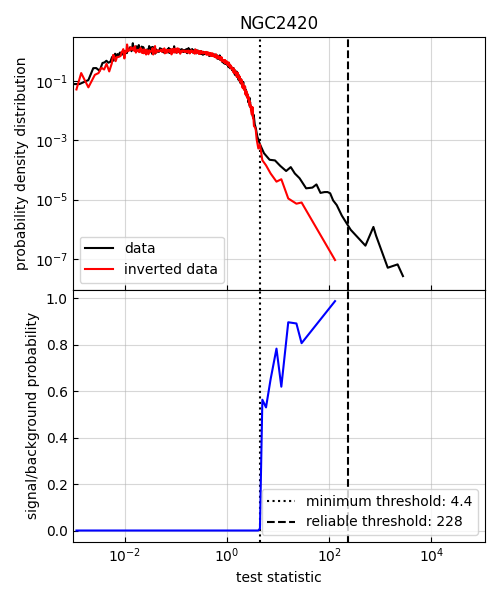

In [16]:
if plots:
    plt.close('test_statistic')
    fig = plt.figure('test_statistic', figsize=(5, 6))
    ax = fig.subplots(nrows=2, ncols=1, squeeze=False,
                      sharex='col', sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        axis.set_aspect('auto')
        th_line = axis.axvline(selection_threshold, c='k', ls=':')
        reliable_line = axis.axvline(reliable_threshold, c='k', ls='--')
    fig.set_tight_layout(True)


    ax[0, 0].set_title(object_name)
    ax[0, 0].set_ylabel('probability density distribution')
    ax[0, 0].set_yscale('log')
    ax[0, 0].set_ylim(np.min(ts_inv.rho)/10, 3)
    ax[0, 0].plot(ts.x_rho, ts.rho, 'k-', label='data')
    ax[0, 0].plot(ts_inv.x_rho, ts_inv.rho, 'r-', label='inverted data')
    #ax[0, 0].plot(ts_inv.x_rho, ts_rho_interp, 'y+', label='interp')
    ax[0, 0].legend()

    ax[1, 0].set_ylabel('signal/background probability')
    ax[1, 0].plot(ts_inv.x_rho, ts_inv_reliability, 'b-')
    th_line.set_label(f'minimum threshold: {selection_threshold:.3g}')
    reliable_line.set_label(f'reliable threshold: {reliable_threshold:.3g}')
    ax[1, 0].legend()

    ax[-1, 0].set_xlim(ts_inv.sorted[0], ts_inv.sorted[-1]*np.sqrt(ts_inv.sorted[-1]/ts_inv.sorted[0]))
    ax[-1, 0].set_xscale('log')
    ax[-1, 0].set_xlabel('test statistic')


In [17]:
true_overdensity = (test_stat > selection_threshold)
#true_overdensity = (test_stat > reliable_threshold)

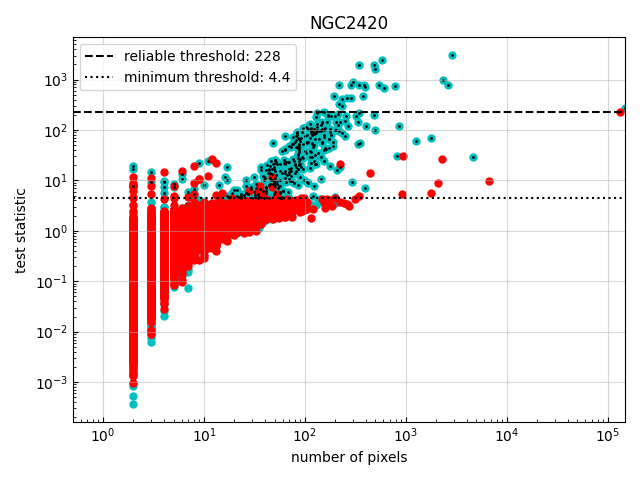

In [18]:
if plots:
    plt.close('catalogue_selection')
    fig = plt.figure('catalogue_selection')
    ax = fig.subplots(nrows=1, ncols=1, squeeze=False,
                      sharex=True, sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0})
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)
    
    ax[0, 0].set_title(object_name)
    ax[0, 0].set_ylabel('test statistic')
    ax[0, 0].set_yscale('log')
    ax[0, 0].scatter(area[1:], test_stat[1:], s=25, c='c')
    ax[0, 0].scatter(area_inv[1:], test_stat_inv[1:], s=25, c='r')
    ax[0, 0].scatter(area[true_overdensity], test_stat[true_overdensity], s=1, c='k')

    ax[0, 0].axhline(reliable_threshold, color='k', ls='--', label=f'reliable threshold: {reliable_threshold:.3g}')
    ax[0, 0].axhline(selection_threshold, color='k', ls=':', label=f'minimum threshold: {selection_threshold:.3g}')

    #ax[0, 0].set_ylim(.1*data.bg_std**2, np.max(test_stat))
    ax[0, 0].set_xlim(.5, np.max(area[1:]))
    ax[0, 0].legend()

    ax[-1, 0].set_xscale('log')
    ax[-1, 0].set_xlabel('number of pixels')

## 8. Clean-up

### prune HOT based on selection threshold

In [19]:
original_labels = np.arange(parent.size)
island = (parent == original_labels)
pruned_labels = np.zeros_like(original_labels)
pruned_labels[true_overdensity | ~island] = original_labels[true_overdensity | ~island]

pruned_OK = true_overdensity[pruned_labels]
to_go = np.count_nonzero(~pruned_OK)
while True:
    print(f'{to_go} yet to go')
    pruned_labels[~pruned_OK] = parent[pruned_labels[~pruned_OK]]
    pruned_OK = true_overdensity[pruned_labels]
    still_to_go = np.count_nonzero(~pruned_OK)
    if still_to_go == to_go:
        break
    else:
        to_go = still_to_go
        #break

pruned_labels[~pruned_OK] = 0

150886 yet to go
122301 yet to go
85575 yet to go
61908 yet to go
53893 yet to go
52358 yet to go
52137 yet to go
52129 yet to go


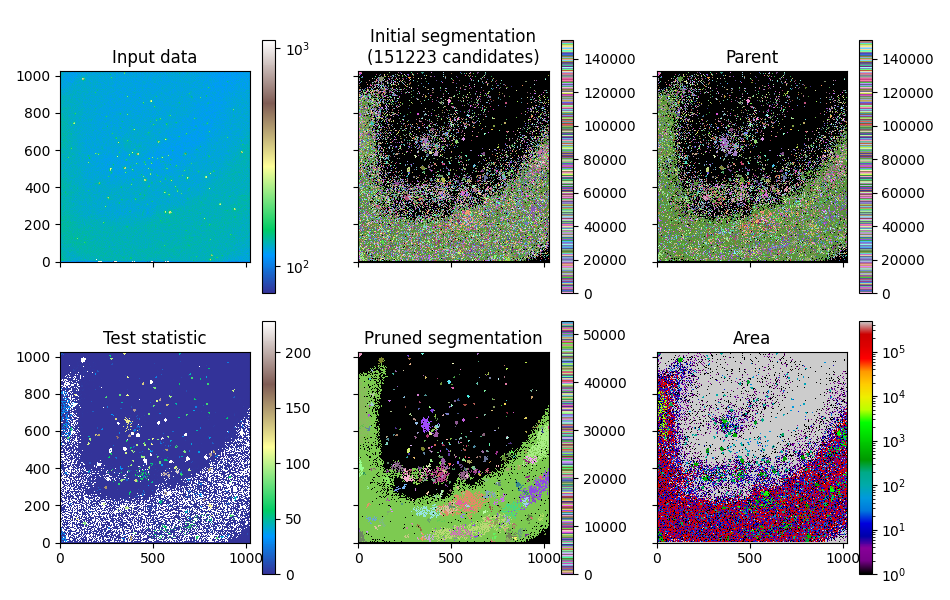

In [20]:
if plots and data_dimensionality == 2:
    segmentation = segm.SegmentationImage(label)
    pruned_segmentation = segm.SegmentationImage(pruned_labels[label])
    plt.close('HOT')
    fig = plt.figure('HOT', figsize=(9.5, 6))
    fig.set_tight_layout(True)
    ax = fig.subplots(nrows=2, ncols=3, sharex=True, sharey=True)

    ax[0, 0].set_title('Input data')
    im = ax[0, 0].imshow(
        data.original,
        interpolation='nearest', origin='lower', cmap='terrain', norm = colour_scale,
        )
    cb = fig.colorbar(im, ax=ax[0, 0])

    ax[0, 1].set_title(f'Initial segmentation\n({parent.size} candidates)')
    im = ax[0, 1].imshow(
        label,
        interpolation='nearest', origin='lower', cmap=segmentation.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[0, 1])

    ax[0, 2].set_title('Parent')
    im = ax[0, 2].imshow(
        parent[label],
        interpolation='nearest', origin='lower', cmap=segmentation.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[0, 2])

    #ax[1, 0].set_title('Max value')
    #ax[1, 0].set_title('Contrast')
    #ax[1, 0].set_title('Max S/N')
    ax[1, 0].set_title('Test statistic')
    im = ax[1, 0].imshow(
        #max_value[label]-min_value[label],
        test_stat[label],
        interpolation='nearest', origin='lower', cmap='terrain',
        #norm=colour_scale,
        vmax=np.nanmax(test_stat_inv[1:])
        )
    cb = fig.colorbar(im, ax=ax[1, 0])

    '''
    ax[1, 1].set_title('S/N threshold')
    im = ax[1, 1].imshow(
        #saddle_value[label],
        signal_to_noise_threshold[label],
        interpolation='nearest', origin='lower', cmap='terrain', norm = colour_scale,
        )
    '''
    ax[1, 1].set_title('Pruned segmentation')
    im = ax[1, 1].imshow(
        pruned_segmentation,
        interpolation='nearest', origin='lower', cmap=pruned_segmentation.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[1, 1])

    ax[1, 2].set_title('Area')
    im = ax[1, 2].imshow(
        area[label],
        interpolation='nearest', origin='lower', cmap='nipy_spectral', norm=colors.LogNorm(),
        )
    cb = fig.colorbar(im, ax=ax[1, 2])


### rename labels and create final catalogues

In [21]:
final_labels = pruned_labels.astype(np.int32)
old_label = np.sort(np.unique(pruned_labels))
new_label = np.zeros_like(parent)
n_final_labels = old_label.size
print(f'{n_final_labels} objects after mode filtering')

for i, lbl in enumerate(old_label):
    new_label[lbl] = i
    final_labels[final_labels == lbl] = i

new_parent = new_label[parent[old_label]]
final_labels = new_label[pruned_labels[label]]

338 objects after mode filtering


In [22]:
#final_labels[data < signal_to_noise_threshold[label]] = 0

In [23]:
if plots and data_dimensionality == 2:
    final_selection = segm.SegmentationImage(final_labels)
    final_cmap = final_selection.make_cmap(seed=123)
    final_catalog = segm.SourceCatalog(data.original, final_selection)
    final_catalog.to_table()

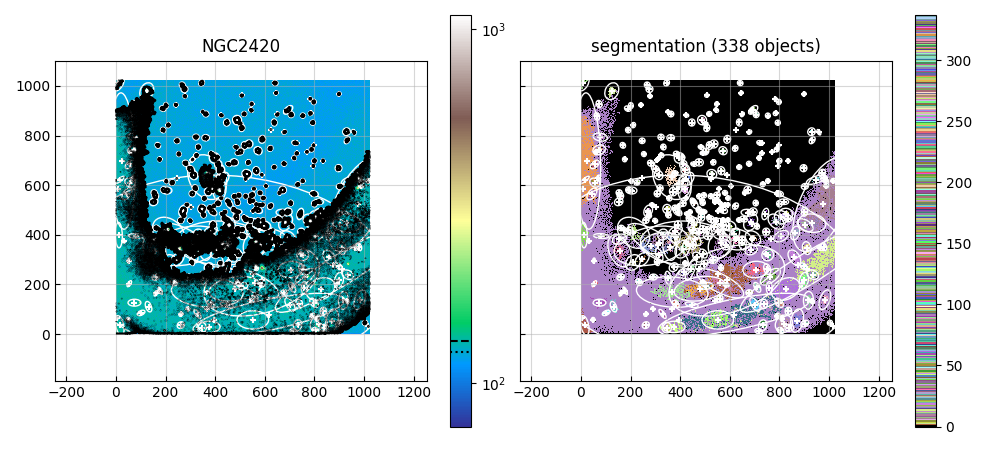

In [24]:
if plots and data_dimensionality == 2:
    plt.close('segmentation')
    fig = plt.figure('segmentation', figsize=(10, 4.5))
    ax = fig.subplots(nrows=1, ncols=2, squeeze=False,
                      sharex=True, sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0})
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)

    ax[0, 0].set_title(object_name)
    im = ax[0, 0].imshow(
        data.original,
        interpolation='nearest', origin='lower', cmap='terrain', norm = colour_scale,
        )
    ax[0, 0].contour(final_labels, levels=[0.5], colors=['k'])
    cb = fig.colorbar(im, ax=ax[0, 0])
    cb.ax.axhline(data.mode, c='k', ls=':')
    cb.ax.axhline(data.threshold, c='k', ls='--')
    final_catalog.plot_kron_apertures(kron_params=(1, 1), axes=ax[0, 0], color='w')
    ax[0, 0].scatter(final_catalog.centroid[:, 0], final_catalog.centroid[:, 1], s=25, c='w', marker='+')

    ax[0, 1].set_title(f'segmentation ({n_final_labels} objects)')
    im = ax[0, 1].imshow(
        final_selection,
        interpolation='nearest', origin='lower', cmap=final_cmap,
        )
    cb = fig.colorbar(im, ax=ax[0, 1])
    ax[0, 1].scatter(final_catalog.centroid[:, 0], final_catalog.centroid[:, 1], s=25, c='w', marker='+')
    final_catalog.plot_kron_apertures(kron_params=(1, 1), axes=ax[0, 1], color='white')


## Save FITS file

In [25]:
'''
hdu_out = fits.PrimaryHDU(final_labels)
hdu_out.writeto('output/HOT_labels.fits', overwrite=True)
'''

"\nhdu_out = fits.PrimaryHDU(final_labels)\nhdu_out.writeto('output/HOT_labels.fits', overwrite=True)\n"